In [1]:
from rigid_kinematics import *
import transforms3d as t3d

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import importlib
#importlib.reload(rigid_kinematics)

In [2]:
pi = np.pi
robot = dh_robot_config(num_joints = 8, alpha = [-pi/2, pi/2, 0, pi/2, pi/2, -pi/2, -pi/2, 0], theta = [0, pi/2, 0, pi/2, pi/2, 0, -pi/2, 0], D = [0, 0, 0, 0, 0, 0, 0, 0.05], a = [0, 0, 0, 0, 0.08, 0.08, 0, 0], jointType = ['p', 'p', 'p', 'r', 'r', 'r', 'r', 'p'], ai = pi/2, aj = 0, ak = 0)

In [3]:
def skew_symmetric(w):
    return np.array([[0, -w[2], w[1]],
                     [w[2], 0, -w[0]],
                     [-w[1], w[0], 0]])

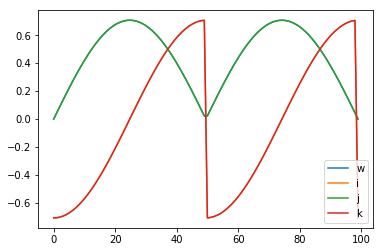

In [4]:
x = np.linspace(0,4*pi,num=100)
y = np.zeros((100,4))
for i in range(100):
    y[i,:] = robot.Orientation_quaternion(3,np.array([0,0,0,x[i],0,0,0,0]))
    
plt.plot(y[:,0])
plt.plot(y[:,1])
plt.plot(y[:,2])
plt.plot(y[:,3])
plt.legend(['w', 'i', 'j', 'k'])

0.043331146240234375
[2.1310482553585377, 0.20265304293426462, 0.03746102548579472, 0.04524592141332888, 0.03837246193824907, 0.026695556617566955, 0.018422496345210704, 0.0125317094256884, 0.008551408837743659, 0.005864418811646721]
[0.33324942373053096, 0.27922795254866156, 0.13755666328996566, 0.04936369059525301, 0.015364838726809554, 0.004485693742614191, 0.0013689154119945035, 0.0004709252695055434, 0.00018417566059354486, 7.95916708044281e-05]


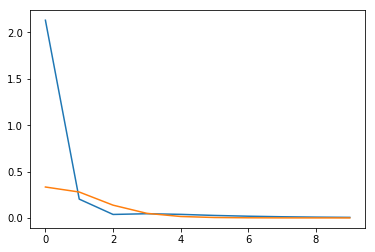

In [5]:
position_error = []
orientation_error = []

seed_joint_angles = np.array([0, 0, 0, 0, 0, 0, 0 ,0])

#initialize positions = [x, y, z]
target_position = np.array([1, 2, 3])

#initialize orientations, quaternion = [w, x, y, z]
#quat_d = t3d.euler.euler2quat(0, 0, 0)#pi/4, pi/4)
quat_d = y[25,:] #this chooses an orientation in the range of our robot, something is messed up with the robot setup right now. confirm with VREP.

qs = seed_joint_angles.copy()
start = time.time()


#this algorithm implements the quaternion IK algorithm presented in 3.7.3 of Robotics: Modelling, Planning and Control
# to do: build full VREP robot and verify FK for position and orientation
# implement Selectively Damped Least squares
for i in range(10):
    current_position = robot.Tx(7, qs)
    quat_e = robot.Orientation_quaternion(7,qs)
    
    e_position = target_position - current_position
    
    #e_quaternion = t3d.quaternions.qmult(t3d.quaternions.qinverse(quat_d),quat_e)
    
    e_orientation = quat_e[0]*quat_d[1:] - quat_d[0]*quat_e[1:] - skew_symmetric(quat_d[1:])@quat_e[1:]
    
    qs = qs + 1*np.linalg.pinv(robot.J_position(7, qs))@e_position
    qs = qs + 1*np.linalg.pinv(robot.J_orientation(7, qs))@e_orientation
    
    position_error.append(np.sqrt(np.mean(e_position**2)))
    orientation_error.append(np.mean(e_orientation**2))#e_quaternion[1:]**2))
print((time.time()-start))

plt.plot(position_error)
plt.plot(orientation_error)
print(position_error)
print(orientation_error)

In [8]:
#forward kinematics speed test

#time FK and Jacobian calculations
num_iters = 100
qs = np.random.rand(num_iters,8)

start = time.time()
for i in range(num_iters):
    robot.Tx(7, qs[i])
print('Time per iter for FK over {} iters: {}'.format(num_iters, (time.time()-start)/num_iters))


start = time.time()
for i in range(num_iters):
    robot.J_position(7, qs[i])
    robot.J_orientation(7, qs[i])
print('Time per iter for Jacobian over {} iters: {}'.format(num_iters, (time.time()-start)/num_iters))

Time per iter for FK over 100 iters: 0.0009000945091247559
Time per iter for Jacobian over 100 iters: 0.002257230281829834
